#### Análise de tweets: Desastre ou não?
- Este é um projeto de ciência de dados de ponta a ponta (da coleta de dados ao deploy), que tem como objetivo <b>analisar</b> um conjunto de <b>tweets</b> e <b>prever a probabilidade de um tweet estar relacionado a um desastre real.</b> Portanto, trata-se de um problema de classificação binária (aprendizado supervisionado, conjunto de dados rotulado) no qual a variável dependente é 1 para o caso de tweets relacionados a desastres reais e 0 para tweets não relacionados.
- O pipeline de solução, com base no framework <B>CRISP-DM</b>, consiste dos seguintes <b>passos:</b><br>

    <b>0. Entendimento do problema de negócio.</b><br>
    <b>1. Entendimento dos dados.</b><br>
    <b>2. Preparação dos dados.</b><br>
    <b>3. Modelagem.</b><br>
    <b>4. Avaliação.</b><br>
    <b>5. Deploy/Implantação.</b><br>

- Neste notebook, será realizada a <b>modelagem para a predição da probabilidade de um tweet estar relacionado a um desastre</b>, cobrindo os passos 3 a 5 do framework supracitado. O objetivo da modelagem consiste em <b>construir um modelo</b> capaz de <b>prever essa chance acuradamente</b> e criar uma <b>Flask API</b>, de forma que seja possível prever a probabilidade de um tweet estar associado a um desastre fornecendo-o em texto.
- Aqui, adotaremos a abordagem de <b>prever a probabilidade</b>, levando em consideração a <b>informação de confiança.</b> Isso nos permite avaliar quão provável é que um determinado tweet represente uma catástrofe real. Tal abordagem facilita a gestão de risco por parte das agências mencionadas no problema de negócio em 'eda.ipynb', possibilitando a <b>priorização da atenção</b> para tweets com maior probabilidade. Além disso, ><b>reduz a propagação de notícias falsas</b>, uma vez que rótulos binários poderiam classificar erroneamente vários tweets, especialmente ao utilizar pontos de corte mais baixos para a classificação (trade-off precision-recall).
- Nesse sentido, <B>métricas</b> como ROC-AUC, PR-AUC, Brier Score e KS serão <b>priorizadas.</b> Entretanto, olharemos para diversas outras. Mesmo adotando o critério probabilístico, é interessante obter um bom recall. O recall pode ser interpretado como o alcance, e de fato, é melhor que "alcancemos" o maior número de desastres reais possível, isto é, que o modelo seja capaz de identificar uma grande parte dos tweets de fato associados a desastres.
- O pipeline de modelagem consiste em:
- 0. Limpeza dos dados.
- 1. Split dos dados em treino e teste, estratificado.
- 2. Pré-processamento de dados.
- 3. Comparação de diversos modelos através de validação cruzada k-fold estratificada.
- 4. Tunagem de hiperparâmetros do modelo com class_weight e otimização bayesiana.
- 5. Avaliação final no conjunto de testes.
- 6. Deploy.
- Cada etapa e cada decisão tomada é abordada em detalhes abaixo. Os insights obtidos na eda guiarão as decisões daqui para frente.

Importando as bibliotecas novamente.

In [126]:
# Data manipulation and visualization.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Modelling, cleaning and preparation.
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from spellchecker import SpellChecker
from collections import Counter
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import spacy
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, auc, brier_score_loss
import time
import math

# Utils.
from src.modelling_utils import *

# Definições de cores -> todas estão numa escala de mais escura para mais clara.
CINZA1, CINZA2, CINZA3 = '#231F20', '#414040', '#555655'
CINZA4, CINZA5, CINZA6 = '#646369', '#76787B', '#828282'
CINZA7, CINZA8, CINZA9 = '#929497', '#A6A6A5', '#BFBEBE'
AZUL1, AZUL2, AZUL3, AZUL4 = '#174A7E', '#4A81BF', '#94B2D7', '#94AFC5'
VERMELHO1, VERMELHO2, VERMELHO3, VERMELHO4, VERMELHO5 = '#DB0527', '#E23652', '#ED8293', '#F4B4BE', '#FBE6E9'
VERDE1, VERDE2 = '#0C8040', '#9ABB59'
LARANJA1 = '#F79747'
AMARELO1, AMARELO2, AMARELO3, AMARELO4, AMARELO5 = '#FFC700', '#FFCC19', '#FFEB51', '#FFE37F', '#FFEEB2'
BRANCO = '#FFFFFF'

# Visualize all the columns.
pd.set_option('display.max_columns', None)


# Filter warnings.
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\peedr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\peedr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\peedr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\peedr\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Coletando novamente os dados.

In [2]:
# Reading the data.
train_path = '../input/train.csv'
test_path = '../input/test.csv'
sample_path = '../input/sample_submission.csv'
df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
sample_df = pd.read_csv(sample_path)

Rápida visualização e informação.

In [3]:
df.head()

,id,keyword,location,text,target
0,1118,blew%20up,"Brooklyn, NY",@YahooSchwab easy way to look good after the R...,0
1,1558,bomb,NaN,@dopeitsval ahh you're bomb baby ??,0
2,4830,evacuation,NaN,Run out evacuation hospital indexing remedial ...,1
3,3674,destroy,Trackside California,Wow Crackdown 3 uses multiple servers in multi...,0
4,5368,fire%20truck,NaN,wild night in the village of pugwash every fir...,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
print(f'O dataset possui {df.shape[0]} linhas e {df.shape[1]} colunas.')

O dataset possui 7613 linhas e 5 colunas.


Valores nulos e duplicados.

In [6]:
isna_df = df.isna().sum().to_frame().rename(columns={0: 'count'})
isna_df['pct'] = isna_df['count'] / len(df) * 100
isna_df.sort_values(by=['pct'], ascending=False)

,count,pct
location,2533,33.272035
keyword,61,0.801261
id,0,0.000000
text,0,0.000000
target,0,0.000000


In [7]:
print(f'Observações duplicadas: {df.duplicated().sum()}.')
print(f'Ids duplicados: {df.id.duplicated().sum()}')

Observações duplicadas: 0.
Ids duplicados: 0


#### 0. Limpeza
- Antes dos split, é necessário limpar os dados, aplicando as mesmas transformações realizadas na eda.
- 1. Remoção de links, tags html, @s de usuários, pontuações, caracteres especiais, números e stopwords (palavras sem natureza informativa) com o objetivo de não prejudicar a semântica, não introduzir ruído, e diminuir a dimensionalidade. Além disso, há uma questão ética em não usar o nome dos usuários. Tudo isso feito através de expressões regulares, que são padrões de texto que permitem realizar buscas complexas e operações de manipulação em strings. Um cheat sheet de referência será usado: https://www.datacamp.com/cheat-sheet/regular-expresso.
- 2. Conversão das palavras a lowercase para padronizá-las e reduzir a dimensionalidade.
- 3. Lematização, para manter a coerência linguística das palavras ao reduzi-las a suas raízes ou lemas. Utiliza-se part of speech tags aqui. Stemming não é aplicado pois, apesar de a lematização ser mais custosa, desejo demonstrar mais conhecimento e técnica. Além disso, no deploy, processaremos um único tweet por vez, não havendo gargalos significativos.
- 4. Para a modelagem, estamos interessados apenas na coluna contendo os tweets como variável independente, portanto, essa será separada das outras.
- Estes passos foram encapsulados em uma função 'clean_text' em 'modelling_utils.py', arquivo que contém funções úteis para a modelagem. 

In [34]:
# Separando apenas as colunas text e target para a modelagem.
clean_df = df[['text', 'target']].copy()
clean_df.head(15)

,text,target
0,@YahooSchwab easy way to look good after the R...,0
1,@dopeitsval ahh you're bomb baby ??,0
2,Run out evacuation hospital indexing remedial ...,1
3,Wow Crackdown 3 uses multiple servers in multi...,0
4,wild night in the village of pugwash every fir...,1
5,This bed looks like a war zone.,0
6,Funds Needed for Rescued then Abandoned Cocker...,0
7,@kshllcenterpri1 @Progress4Ohio burning down b...,1
8,:: Survive??,0
9,Do you have an emergency drinking water plan? ...,0


In [35]:
# Acessando o resultado.
clean_df = nlp_data_cleaning(clean_df)
clean_df['clean_text'].head(15)

0           easy way look good ray rice fiascothat blow
1                                   ahh youre bomb baby
2     run evacuation hospital index remedial angiopl...
3     wow crackdown us multiple server multiplayer u...
4     wild night village pugwash every fire truck to...
5                                bed look like war zone
6               fund need rescue abandon cocker spaniel
7            burn building mean like burnt black church
8                                               survive
9     emergency drink water plan download guide engl...
10    california fire rage forest service sound alar...
11               something place prevent skynet perhaps
12           new smp ignition knock detonation sensor k
13    memorial unveil travis county deputy kill sept...
14    live balance life balance fear # allah hope me...
Name: clean_text, dtype: object

#### 1. Split dos dados em treino e teste, estratificado.
- Dados de teste devem ser dados que o modelo nunca viu, simulando o ambiente de produção e obtendo uma avaliação de performance confiável do nosso estimador. Por isso, este conjunto será obtido e isolado apenas para avaliação final, uma vez que já selecionamos e tunamos o melhor modelo.
- rei especificar o parâmetro stratify=y. Isso fará com que a proporção das classes positiva (tweets relacionados a desastres) e negativa (tweets não relacionados a desastre) do target sejam mantidas em todos os conjuntos, evitando que o desbalanceamento (mesmo que sutil) afete as nossas amostras e a nossa avaliação de performance futura. Queremos o fenômeno bem representado em cada uma das amostras.

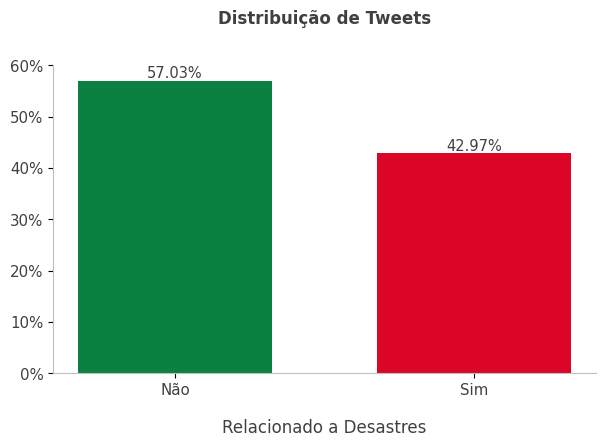

In [14]:
# Agrupando os dados.
disaster_grouped = clean_df.groupby(['target'])[['target']].count().rename(columns={'target': 'count'}).reset_index().sort_values(by=['count'], ascending=False)
disaster_grouped['pct'] = round(disaster_grouped['count'] / np.sum(disaster_grouped['count']) * 100, 2) 

# Plot e customização.
fig, ax = plt.subplots(figsize=(7, 4))
bars = ax.bar(x=disaster_grouped['target'], height=disaster_grouped['pct'], color=[VERDE1, VERMELHO1], width=0.65)
for bar, pct in zip(bars, disaster_grouped['pct']):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{pct}%', ha='center', color=CINZA2, fontsize=10.5)
ax.set_title('Distribuição de Tweets', color=CINZA2, fontweight='bold', fontsize=12, pad=30)
ax.set_xlabel('Relacionado a Desastres', labelpad=15, color=CINZA2, fontsize=12)
ax.set_xticks(ticks=disaster_grouped['target'], labels=['Não', 'Sim'], color=CINZA2, fontsize=10.8)
ax.set_yticks(ticks=np.arange(0, 61, 10), labels=['0%', '10%', '20%', '30%', '40%', '50%', '60%'] , color=CINZA2, fontsize=10.8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color(CINZA9)
ax.spines['bottom'].set_color(CINZA9)
plt.show()

In [79]:
X = clean_df['clean_text']
y = clean_df['target'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f'Train predictor set shape: {X_train.shape}. Train target set shape: {y_train.shape}')
print(f'Test predictor set shape: {X_test.shape}. Test target set shape: {y_test.shape}.')

Train predictor set shape: (6090,). Train target set shape: (6090,)
Test predictor set shape: (1523,). Test target set shape: (1523,).


In [80]:
print(f'Train set target classes proportions: ')
print(y_train.value_counts(normalize=True))
print(f'\nTest set target classes proportions:')
print(y_test.value_counts(normalize=True))

Train set target classes proportions: 
target
0    0.570279
1    0.429721
Name: proportion, dtype: float64

Test set target classes proportions:
target
0    0.570584
1    0.429416
Name: proportion, dtype: float64


Perfeito! A divisão dos dados em treino e teste foi feita corretamente e a proporção das classes do target foi mantida em cada um desses conjuntos.

#### 2. Pré-processamento dos dados/Representação de texto como vetores numéricos
- Existem três abordagens comuns para representar os tweets (texto) como vetores numéricos para treinar algoritmos de machine learning:
- 1. Bag of Words:
    - Cada texto é tratado como um "saco" (conjunto não ordenado) de palavras, ignorando a ordem e a estrutura gramatical. 
    - - 1. Tokenização: Divide o tweet em palavras individuais (tokens), considerando limpezas como remoção de pontuações, stopwords, lowercase, entre outras.
    - - 2. Construção do Vocabulário: Cria um vocabulário único - Todas as palavras únicas presentes nos tweets.
    - - 3. Vetorização: Representa cada tweet como um vetor, onde cada posição no vetor corresponde a uma palavra do vocabulário (coluna) e o valor na posição indica a contagem da palavra no tweet.
    - Biblioteca Scikit-Learn implementa.
    - Vantagem: Simplicidade e eficiência computacional.
    - Desvantagem: Perda de informações semânticas e sobre a ordem das palavras, além da estrutura gramatical.
    - Pode-se incluir, após o Bag of Words, o TF-IDF também. 
    - A Frequência do Termo-Inverso da Frequência do Documento (TF-IDF) é uma técnica que combina a Frequência do Termo (TF), que mede a importância de um termo em um documento específico, com a Inverso da Frequência do Documento (IDF), que penaliza termos que são muito comuns em todo o corpus. O TF-IDF é usado para avaliar a importância relativa de um termo em relação a um conjunto de documentos. Em resumo, TF-IDF destaca termos que são frequentes em um documento específico, mas não tão comuns em todo o corpus, identificando assim termos distintivos e informativos.
- 2. Word Vectors:
    - Representação de palavras como vetores numéricos em um espaço contínuo, capturando relações semânticas e contextuais entre palavras.
    - Modelos treinados em grandes corpora de texto para aprender representações vetoriais, onde palavras semanticamente similares ficam próximas no espaço vetorial.
    - Cada dimensão do vetor é uma característica específica da palavra.
    - Biblioteca Spacy implementa.
    - Vantagens: Captura relações semânticas e contextuais entre palavras.
    - Desvantagem: Pode ter dificuldades com palavras raras ou fora do vocabulário durante o treinamento.
- 3. BERT:
    - Modelo de linguagem pré-treinado baseado em transformers. Ele utiliza uma arquitetura de transformer bidirecional para aprender representações contextuais de palavras em uma sentença. Ao contrário de modelos anteriores que processam palavras em uma única direção (da esquerda para a direita ou vice-versa), o BERT considera o contexto de todas as palavras em uma sentença, o que melhora a compreensão das nuances do significado das palavras.
    - Biblioteca Spacy implementa.
    - Vantagens: Compreensão contextual bidirecional, capturando nuances semânticas e melhorando o desempenho em tarefas complexas.
    - Desvantagens: Requer recursos computacionais significativos para treinamento.
- Considerando meus recursos computacionais limitados, escolherei apenas o Bag of Words para a representação de texto em vetores numéricos. Isso permitirá o treinamento e predição mais rápidos, facilitando também o deploy. É muito melhor para o usuário obter o resultado que ele deseja em menor tempo, do que manter-se em espera. Além disso, é esperado que essa abordagem forneça um desempenho satisfatório, uma vez que realizamos uma limpeza efetiva no conjunto de dados.
- Ao aplicar transformações em dados de texto, como "Bag of Words", iremos obter matrizes esparsas. Essas matrizes são representações eficientes onde a maioria dos elementos são zeros, economizando espaço de armazenamento, pois muitas palavras podem não estar presentes em cada documento, resultando em uma matriz esparsa com apenas valores não nulos onde as palavras ocorrem.
- Após representar os tweets como vetores numéricos que podem ser usados para treinar algoritmos de machine learning, devemos treinar classificadores. Isso será feito na próxima etapa. Por enquanto, vamos aplicar a representação escolhida abaixo:

In [132]:
# Bag of Words.
count_vectorizer = CountVectorizer(analyzer='word',
                                   stop_words='english',
                                   ngram_range=(1, 3),
                                   token_pattern=r'\w{1,}',
                                   )
count_vectorizer.fit(X_train)

X_train_bow = count_vectorizer.transform(X_train)
X_test_bow = count_vectorizer.transform(X_test)

# LightGBM exige tipos float para o treinamento.
X_train_bow_float = X_train_bow.astype('float32')
y_train_float = y_train.astype('float32')

X_train_bow

<6090x73558 sparse matrix of type '<class 'numpy.int64'>'
	with 125913 stored elements in Compressed Sparse Row format>

#### 3. Treinamento, comparação e seleção de modelos - Validação cruzada k-fold
- Nesta etapa, irei comparar a performance de diferentes modelos. Para isso, utilizarei a validação cruzada k-fold para treinar cada modelo, avaliando o seu ROC-AUC.
- Os modelos escolhidos para teste serão a Regressão Logística, Linear SVC, Random Forest e LightGBM.
- O meu objetivo aqui é selecionar o(s) modelo(s) promissores, isto é, aqueles que apresentam o maior ROC-AUC na validação cruzada, para seguir para as etapas de tunagem de hiperparâmetros e avaliação final no conjunto de testes, simulando o ambiente de produção.
- O ROC-AUC é uma medida que nos informa a capacidade discriminante do modelo, isto é, a capacidade de discriminar entre tweets relacionados a desastres (1) e tweets não relacionados (0). Ela consiste na área abaixo da curva ROC, que plota tpr (true positive rate, ou recall/sensibilidade) vs fpr (false positive rate, ou 1 - especificidade).
- Na validação cruzada k-fold, dividimos o conjunto de treinamento em k folds, avaliando em cada um dos k-ésimos folds um modelo treinado nos k-1 folds. Isso permitirá que eu obtenha uma medida robusta de como cada um performa, mitigando efeitos da variabilidade dos dados. Além disso, também será evitado o overfitting, uma vez que será possível, de antemão, observar como o modelo desempenha em dados nunca antes vistos.
- Dado o ligeiro desbalanceamento, para fins de rigorosidade de método, irei aplicar, da mesma forma que no split, uma divisão estratificada dos folds.

- Dicionário de modelos a serem avaliados.

In [130]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Linear SVM': LinearSVC(),
    'Random Forest': RandomForestClassifier(),
    'LightGBM': LGBMClassifier(verbose=-1)
}

- Validação cruzada k-fold: Bag of Words.

In [135]:
eval_df = evaluate_models_cv_classification(models=models, 
                                            X_train=X_train_bow_float, 
                                            y_train=y_train, 
                                            n_folds=5)
eval_df

In [133]:
from sklearn.linear_model import LogisticRegression

logwv = LogisticRegression()
logwv.fit(X_train_bow, y_train)

p = logwv.predict(X_test_bow)
from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_test, p))
print(roc_auc_score(y_test, p))

              precision    recall  f1-score   support

           0       0.77      0.89      0.83       869
           1       0.82      0.65      0.72       654

    accuracy                           0.79      1523
   macro avg       0.80      0.77      0.78      1523
weighted avg       0.79      0.79      0.78      1523

0.7696955620541731
